In [1]:
%matplotlib inline
from data_fetch import prepare_usps_mlfetch
[Xtrue,Xlabels] = prepare_usps_mlfetch()
data = Xtrue

importing usps from pickle file .....


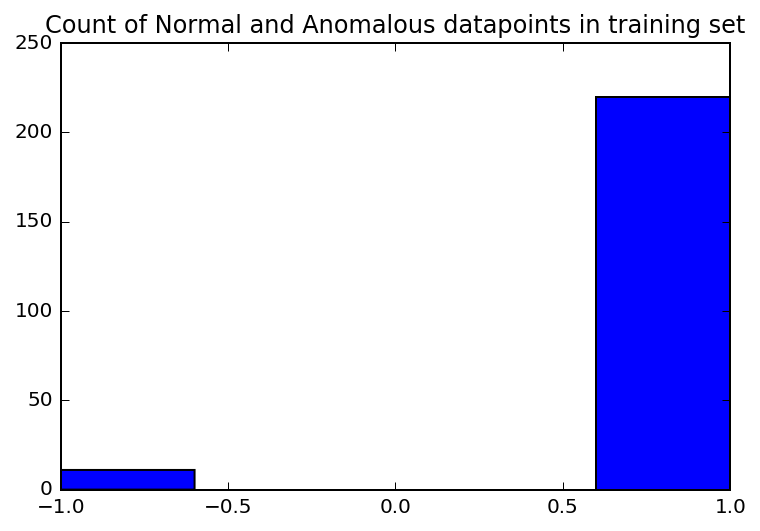

In [2]:
%config InlineBackend.figure_format = 'retina'
# let's take a look at the types of labels  are present in the data.
# The ones correspond to label 1 and 7's(outliers) correspond to label -1
#data.label.value_counts().plot(kind='bar')  
type(Xlabels)
import matplotlib.pyplot as plt
plt.hist(Xlabels,bins=5)
plt.title("Count of Normal and Anomalous datapoints in training set")
plt.show()

##### MAKING OUR DATA ONE-CLASS

Later we're going to use scikit-learn's OneClassSVM predict function to generate output. This returns +1 or -1 to indicate whether the data is an "inlier" or "outlier" respectively. To make comparison easier later we'll replace our data's label with a matching +1 or -1 value. This also transforms our data from multi-class (multiple different labels) to one-class (boolean label), which is a prerequisite for using a one-class SVM




In [3]:

# series, not a new dataframe
target = Xlabels
# find the proportion of outliers we expect (aka where `labels == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/target.shape[0])

# Print the shape of the input data for sanity
print "Training data shape...",data.shape
# temp =  data[0:180]
# print temp.shape
# print data[1]
# data = data[0:220]
# target = target[0:220]

('outliers.shape', (11,))
('outlier fraction', 0.047619047619047616)
Training data shape... (231, 256)


#### SPLITTING DATA INTO TRAINING AND TEST SETS



In [4]:
# from sklearn.cross_validation import train_test_split
# train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
# train_data.shape  


# # We learn the digits on the first half of the digits
# data_train, targets_train = train_data,train_target

# # Now predict the value of the digit on the second half:
# data_test, targets_test = test_data,test_target

data_train = data[0:219]
targets_train = target[0:219]
data_test = data[220:231]
targets_test = target[220:231]

### TRAINING THE MODELS: OneClass SVM

In [5]:

from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA
from sklearn import metrics 

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()
oneClass_svm = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)
oneClass_svm_time = time()
oneClass_svm.fit(data_train) 
preds = oneClass_svm.predict(data_test)  
print "One Class SVM output: for negative values are"
print preds

('nu', 0.047619047619047616)
One Class SVM output: for negative values are
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


### Single Hidden Layer : One ClassNeural Network

In [15]:
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression,oneClassNN
from tflearn.metrics import binary_accuracy_op
from time import time
from sklearn import metrics 
import tensorflow as tf

# Clear all the graph variables created in previous run and start fresh
tf.reset_default_graph()
init = tf.global_variables_initializer()
#Training examples
X = data_train
# Y = [[0], [0], [0], [0]]
Y = targets_train
# Y = list(Y)
Y = Y.tolist()
Y= [[i] for i in Y]

# For testing the algorithm
X_test = data_test
Y_test = targets_test
Y_test= Y_test.tolist()
Y_test= [[i] for i in Y_test]

m,n = data_train.shape
No_of_inputNodes = n
No_of_hiddenNodes=n
print "No_of_hiddenNodes",No_of_hiddenNodes

input_layer = input_data(shape=[None, No_of_inputNodes]) #input layer of size 2
hidden_layer = fully_connected(input_layer , No_of_hiddenNodes, activation='sigmoid',name="hiddenLayer_Weights") #hidden layer of size 2
output_layer = fully_connected(hidden_layer, 1, activation='sigmoid',name="outputLayer_Weights") #output layer of size 1

# Hyper parameters for the one class Neural Network
v = 0.04
import tflearn.variables as va
# rho = va.variable(name='rho', shape=[])
rho=0.3
#use Stohastic Gradient Descent and Binary Crossentropy as loss function
oneClassNN = oneClassNN(output_layer,v,rho,hidden_layer,output_layer,optimizer='sgd', loss='OneClassNN_Loss', learning_rate=5)
model = DNN(oneClassNN,tensorboard_verbose=3)
#fit the model
model.fit(X, Y, n_epoch=200, show_metric=True);
data_train = data[0:219]
y_pred = model.predict(data_train) # Apply some ops

# Define the Iteration for optimising and stabilizing the value of r
iterStep = 0
# sess = tf.Session()
# sess.run(init)
import numpy as np
rho_previous = rho
rho_next = 0
# Loop till the value of rho stabilizes
while ((rho_previous - rho_next) <= 0.00001):
    print "Running Iteration :",iterStep
    yHat = model.predict(data_train) # Apply some ops
    y_pred = np.sort(-y_pred)
    rhoIndex = int(v * len(data_train))
    rho=(y_pred[rhoIndex] + y_pred[rhoIndex+1])/2
    rho_next =rho 
    model.fit(X, Y, n_epoch=200, show_metric=True)
    iterStep = iterStep + 1

#The data_train and data_test 
data_train = data[0:219]
y_pred = model.predict(data_train) # Apply some ops
print "Training Pridicted output:"
print y_pred

data_test = data[220:231]
y_pred = model.predict(data_test)
print "Test Pridicted output:"
print y_pred

# if(tf.reduce_mean() == v):
#     #Stop the optimization
# else:
#     rho=(1/v)*y_pred
#     #use Stohastic Gradient Descent and Binary Crossentropy as loss function
#     oneClassNN = oneClassNN(output_layer,v,rho,hidden_layer,output_layer,optimizer='sgd', loss='OneClassNN_Loss', learning_rate=5)
#     model = DNN(oneClassNN,tensorboard_verbose=3)
#     #fit the model
#     model.fit(X, Y, n_epoch=200, show_metric=True)
#     y_pred = model.predict(data_train) # Apply some ops


Training Step: 799  | total loss: 0.00105 | time: 0.020s
| SGD | epoch: 200 | loss: 0.00105 - binary_acc: 1.0000 -- iter: 192/219
Training Step: 800  | total loss: 0.00105 | time: 0.026s
| SGD | epoch: 200 | loss: 0.00105 - binary_acc: 1.0000 -- iter: 219/219
--
Training Pridicted output:
[[  2.09982048e-07]
 [  2.13689248e-07]
 [  2.05036258e-07]
 [  2.07125211e-07]
 [  2.29722588e-07]
 [  2.12234085e-07]
 [  2.06689720e-07]
 [  2.07003765e-07]
 [  2.15179867e-07]
 [  2.07955310e-07]
 [  2.06024524e-07]
 [  2.10179394e-07]
 [  2.13078778e-07]
 [  2.10450352e-07]
 [  2.29579342e-07]
 [  2.23694911e-07]
 [  2.06763445e-07]
 [  2.32623847e-07]
 [  2.07326778e-07]
 [  2.13661124e-07]
 [  2.08935134e-07]
 [  2.07603179e-07]
 [  2.08362067e-07]
 [  2.08539788e-07]
 [  2.06335216e-07]
 [  2.04963925e-07]
 [  2.07392631e-07]
 [  2.17709498e-07]
 [  2.31573580e-07]
 [  2.13478629e-07]
 [  2.08003911e-07]
 [  2.07675072e-07]
 [  2.15510084e-07]
 [  2.06920859e-07]
 [  2.09353189e-07]
 [  2.0680

In [23]:


# # y_pred = model.predict(data_test)
# oneClass_nn_time = time() 
# preds = model.predict(X_test)
# targs = targets_test

# oneClass_nn_score = metrics.accuracy_score(targs, preds.round())  
# # Compute the AUC for OneClassNN
# fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
# oneClass_nn_auc_score = metrics.auc(fpr, tpr)
# # oneClass_nn_score = metrics.accuracy_score(targs, np.ones((len(targs),)))  
# oneClass_nn_time = time() - oneClass_nn_time
# print "OneClassNN- Classifier Accuracy",oneClass_nn_score,oneClass_nn_time
# print "OneClassNN- Classifier AUC:",oneClass_nn_auc_score,oneClass_nn_time

Training Pridicted output:
[[ 0.99995577]
 [ 0.99995553]
 [ 0.99995589]
 [ 0.99995589]
 [ 0.99995482]
 [ 0.99995565]
 [ 0.99995589]
 [ 0.99995589]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995589]
 [ 0.99995565]
 [ 0.99995553]
 [ 0.99995565]
 [ 0.99995482]
 [ 0.99995506]
 [ 0.99995589]
 [ 0.9999547 ]
 [ 0.99995577]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995577]
 [ 0.99995577]
 [ 0.99995577]
 [ 0.99995589]
 [ 0.99995589]
 [ 0.99995577]
 [ 0.99995542]
 [ 0.99995482]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995577]
 [ 0.99995542]
 [ 0.99995589]
 [ 0.99995577]
 [ 0.99995589]
 [ 0.99995565]
 [ 0.99995577]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995589]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995577]
 [ 0.9999553 ]
 [ 0.99995553]
 [ 0.99995577]
 [ 0.99995542]
 [ 0.99995589]
 [ 0.99995553]
 [ 0.9999553 ]
 [ 0.99995506]
 [ 0.99995589]
 [ 0.99995565]
 [ 0.99995553]
 [ 0.99995518]
 [ 0.99995589]
 [ 0.99995518]
 [ 0.99995565]
 [ 0.9999547 ]
 [ 0.99995577]
 [ 0.99995542]
 [ 0.99995589]
 [ 0.99995542]
 [ 0.99995577

### TRAINING THE MODELS: OneClass SVM, LINEAR KERNEL with Random Fourier Features, RBF kernel

In [5]:
from sklearn import svm

# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0]) / target.shape[0]  
print("nu", nu)
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.decomposition import PCA
from sklearn import metrics 

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()
oneClass_svm = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)  
# oneClass_svm = svm.OneClassSVM(nu=nu, kernel='linear', gamma=0.00005)
# create pipeline from kernel approximation
# and linear svm
feature_map_fourier = RBFSampler(gamma=.2, random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("svm", svm.LinearSVC())])

OneClass_svm_Linear_fourier = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                          ("svm", svm.OneClassSVM(nu=nu, kernel='linear', gamma=0.00005))])

# fit and predict using linear and kernel svm:

kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)

kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

## Compute AUC for the Linear SVM classifier performance
preds = kernel_svm.predict(data_test)  
targs = targets_test
fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
kernel_svm_auc_score = metrics.auc(fpr, tpr)
kernel_svm_time = time() - kernel_svm_time
print "kernel_svm Classifier AUC:",kernel_svm_auc_score,kernel_svm_time

print "Kernel SVM-Targets and predicted.."
print targs
print preds

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
preds = linear_svm.predict(data_train)  
targs = targets_train

## Compute AUC for the Linear SVM classifier performance
preds = linear_svm.predict(data_train)  
targs = targets_train
fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
linear_svm_auc_score = metrics.auc(fpr, tpr)
linear_svm_time = time() - linear_svm_time
# print "linear_svm Classifier AUC:",linear_svm_auc_score,linear_svm_time


oneClass_svm_time = time()
oneClass_svm.fit(data_train) 
preds = oneClass_svm.predict(data_test)  
targs = targets_test
oneClass_svm_score = metrics.accuracy_score(targs, preds)  
oneClass_svm_time = time() - oneClass_svm_time

print "oneClass_svm and predicted.."
print targs
print preds

# Compute the AUC for oneClass_svm
fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
oneClass_svm_auc_score = metrics.auc(fpr, tpr)
print "oneClass_svm Classifier AUC:",oneClass_svm_auc_score,oneClass_svm_time

## Use Sampling for RFF method 
sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
fourier_times = []
fourier_auc_scores= []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    fourier_scores.append(fourier_score)
    
    ## Compute AUC for the FF  classifier performance
    preds = fourier_approx_svm.predict(data_test)  
    targs = targets_test
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    fourier_approx_auc_score = metrics.auc(fpr, tpr)
    fourier_auc_scores.append(fourier_approx_auc_score)
#     print "fourier_approx_svm Classifier AUC:",fourier_approx_auc_score,fourier_times


## Use Sampling for OneClassSVM + Linear Kerner+ fouriier features method 
sample_sizes = 30 * np.arange(1, 10)
OneClass_svm_Linear_fourtier_scores = []
OneClass_svm_Linear_fourtier_times = []
OneClass_svm_Linear_fourtier_auc_scores= []

for D in sample_sizes:
    OneClass_svm_Linear_fourier.set_params(feature_map__n_components=D)
    start = time()
    OneClass_svm_Linear_fourier.fit(data_train)
    OneClass_svm_Linear_fourtier_times.append(time() - start)
    preds = OneClass_svm_Linear_fourier.predict(data_test)  
    targs = targets_test
    
    OneClass_svm_Linear_fourtier_score = metrics.accuracy_score(targs, preds)  
    OneClass_svm_Linear_fourtier_scores.append(OneClass_svm_Linear_fourtier_score)
    
    ## Compute AUC for the FF  classifier performance
#     preds = OneClass_svm_Linear_fourier.predict(data_train)  
#     targs = targets_train
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    OneClass_svm_Linear_fourtier_auc_score = metrics.auc(fpr, tpr)
    OneClass_svm_Linear_fourtier_auc_scores.append(OneClass_svm_Linear_fourtier_auc_score)
#     print "fourier_approx_svm Classifier AUC:",fourier_approx_auc_score,fourier_times

print "OneClass_svm_Linear_fourier and predicted..."
print targs
print preds

('nu', 0.047619047619047616)


ValueError: The number of classes has to be greater than one; got 1

In [21]:
# from data_fetch import prepare_usps_mlfetch
# [Xtrue,Xlabels] = prepare_usps_mlfetch()
# data = Xtrue
# target = Xlabels
# from sklearn.cross_validation import train_test_split
# train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)
# train_data.shape


# # We learn the digits on the first half of the digits
# data_train, targets_train = train_data,train_target
# # Now predict the value of the digit on the second half:
# data_test, targets_test = test_data,test_target




### Test the Model Trained

In [ ]:
# import tflearn
# var= tflearn.variables.get_all_trainable_variable()
# print type(var)
# for v in var:
#     print v
print preds.shape

### Plotting the Accuracy 

In [20]:
print fourier_auc_scores
print OneClass_svm_Linear_fourtier_auc_scores

[0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.5]
[0.69444444444444442, 0.94444444444444442, 0.93333333333333335, 0.91111111111111109, 0.93333333333333335, 0.94444444444444442, 0.91111111111111109, 0.81111111111111112, 0.90000000000000002]


In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(8, 8))
# accuracy = plt.subplot(111)
# second y axis for timeings
# timescale = plt.subplot(111)

# print "OneClassNN",oneClass_nn_score,oneClass_nn_time
# print"oneClass_svm_score", oneClass_svm_score,oneClass_svm_time
# print"linear_svm_score", linear_svm_score,linear_svm_time
# print "kernel_svm_score", kernel_svm_score,kernel_svm_time
# print "fourier_scores", np.mean(fourier_scores),np.mean(fourier_times)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# basepath = "/Users/raghav/Documents/Uni/ECML_2017/experiments/cifar_10/"
mse = np.zeros((1,5))

# mse[:,0] = np.asarray(oneClass_svm_score)
mse[:,0] = np.asarray(np.mean(OneClass_svm_Linear_fourtier_scores))
mse[:,1] = np.asarray(oneClass_svm_score)



mse[:,2] = np.asarray(kernel_svm_score)
mse[:,3] = np.asarray(np.mean(fourier_scores))
mse[:,4] = np.asarray(oneClass_nn_score)

df = pd.DataFrame(mse, columns=['OC-SVM-LFF', 'OC-SVM-RBF','RBF-SVM', 'RFF-SVM','OneClass-NN'])
df.plot.box()
plt.title('Classifier Performance',fontsize=12,fontweight="bold")
plt.ylabel(" Accuracy",fontsize=12,fontweight="bold")
plt.xticks(rotation=45)


### Plot the AUC Acore for various methods

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(8, 8))
# accuracy = plt.subplot(111)
# second y axis for timeings
# timescale = plt.subplot(111)

# print "OneClassNN",oneClass_nn_score,oneClass_nn_time
# print"oneClass_svm_score", oneClass_svm_score,oneClass_svm_time
# print"linear_svm_score", linear_svm_score,linear_svm_time
# print "kernel_svm_score", kernel_svm_score,kernel_svm_time
# print "fourier_scores", np.mean(fourier_scores),np.mean(fourier_times)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# basepath = "/Users/raghav/Documents/Uni/ECML_2017/experiments/cifar_10/"
mse = np.zeros((1,5))

# mse[:,0] = np.asarray(oneClass_svm_auc_score)

mse[:,0] = np.asarray(np.mean(OneClass_svm_Linear_fourtier_auc_scores))
mse[:,1] = np.asarray(oneClass_svm_auc_score)
mse[:,2] = np.asarray(kernel_svm_auc_score)
mse[:,3] = np.asarray(np.mean(fourier_auc_scores))
mse[:,4] = np.asarray(oneClass_nn_auc_score)

df = pd.DataFrame(mse, columns=['OC-SVM-LFF', 'OC-SVM-RBF','RBF-SVM', 'RFF-SVM','OneClass-NN'])
df.plot.box()
plt.title('Classifier AUC Performance',fontsize=12,fontweight="bold")
plt.ylabel(" AUC",fontsize=12,fontweight="bold")
plt.xticks(rotation=45)


In [ ]:
# print " Predictions of One Class NN"
# # print Y_test
# # print preds


xtestDF_OC_RBF = oneClass_svm.decision_function(X_test)
xtestDF_OC_LFF = OneClass_svm_Linear_fourier.decision_function(X_test)

print " One Class SVM - Decision Functions"
print xtestDF_OC_RBF
print Y_test
print " ##############################################"
print xtestDF_OC_LFF
print Y_test
## But how can we know the decision function for Neural Networks

### PLotting the decision functions

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.font_manager
# from sklearn import svm

# nx, ny = (len(data), 256)
# x = np.linspace(-1, 1, nx)
# y = np.linspace(-1, 1, ny)
# xx, yy =  np.meshgrid(x, y)

# # xx, yy = np.meshgrid(np.linspace(-1, 1, 231), np.linspace(-1, 1, 231))
# ### Synthetic Data
# # # Generate train data
# # X = 0.3 * np.random.randn(100, 2)
# # X_train = np.r_[X + 2, X - 2]
# # # Generate some regular novel observations
# # X = 0.3 * np.random.randn(20, 2)
# # X_test = np.r_[X + 2, X - 2]
# # # Generate some abnormal novel observations
# # X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# ## USPS Data
# X_train = data[0:180]
# X_test = data[181:219]
# X_outliers = data[220:231]


# # fit the model
# clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
# clf.fit(X_train)
# y_pred_train = clf.predict(X_train)
# y_pred_test = clf.predict(X_test)
# y_pred_outliers = clf.predict(X_outliers)
# n_error_train = y_pred_train[y_pred_train == -1].size
# n_error_test = y_pred_test[y_pred_test == -1].size
# n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# # plot the line, the points, and the nearest vectors to the plane
# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# plt.title("Novelty Detection")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

# b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
# plt.axis('tight')
# plt.xlim((-1, 1))
# plt.ylim((-1, 1))
# plt.legend([a.collections[0], b1, b2, c],
#            ["learned frontier", "training observations",
#             "new regular observations", "new abnormal observations"],
#            loc="upper left",
#            prop=matplotlib.font_manager.FontProperties(size=11))
# plt.xlabel(
#     "error train: %d/200 ; errors novel regular: %d/40 ; "
#     "errors novel abnormal: %d/40"
#     % (n_error_train, n_error_test, n_error_outliers))
# plt.show()
